# Expert Feature Analysis

In this notebook, we analyze the features and errors made by the simulate expert on IMDB, SRAA and Twitter data. We will discuss: 

* Features relevant to classes based on the expert model
* How the features change from different models (L1 vs L2)
* What are the difficult snippets to classify (where is the expert making mistakes)

## Configuration of Experiment

We test two expert models: losgist regression with L1 regularization, and L2 regularization. Both models will use a deafult C parameter (C=1). The expert is trained on half of the data (training portion of the dataset), same procedure as performed for the active learning experiments. The expert is trained on the snippets from the data. 

We select N random snippets and test the expert accuracy, confidence, and evaluate the errors. 


## 1. Experiment Settings

* Imports
* Loading data
* Fitting experts
* Setting test data



In [47]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))


In [13]:
import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('bmh')


In [14]:
# Loading Data
rnd = np.random.RandomState(2345)
vct = exputil.get_vectorizer({'vectorizer':"tfidf", 'limit':None, 'min_size':None})

def load_data(dataname, path):
    import pickle

    DATA_PKL = path + '/data.pkl'

    if os.path.isfile(DATA_PKL):
        vct, data = pickle.load(open(DATA_PKL, 'rb'))
    else:
        vct = exputil.get_vectorizer({'vectorizer':"tfidf", 'limit':None, 'min_size':None})
        data = datautil.load_dataset(dataname, path, categories=None, rnd=5463, shuffle=True)
        data.train.data = np.array(data.train.data, dtype=object)
        data.test.data = np.array(data.test.data, dtype=object)
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
        pickle.dump((vct, data), open(DATA_PKL, 'wb'))

    return data, vct



In [17]:
# Get the sentences for testing
def _sentences(docs, doc_labels, sent_tk):
    data = []
    true_labels = []
    sent = sent_tk.tokenize_sents(docs)
    for sentences, doc_label in zip(sent, doc_labels):
        data.extend(sentences)
        true_labels.extend([doc_label] * len(sentences))
    return data, np.array(true_labels)




In [18]:
# Expert Settings
imdb, vct = load_data('imdb', IMDB_DATA)

exp_sent, exp_lbl = _sentences(imdb.train.data, imdb.train.target, sent_tk)
exp_sent_bow = vct.transform(exp_sent)


expertl2 = exputil.get_classifier('lrl2', parameter=1)
expertl1 = exputil.get_classifier('lr', parameter=1)

expertl2.fit(exp_sent_bow, exp_lbl)
expertl1.fit(exp_sent_bow, exp_lbl)

sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')


## Get Test data ready
test_docs = rnd.permutation(len(imdb.test.target))


In [21]:
# Prepare testing data
n=1000

# sent = sent_tk.tokenize_sents(imdb.test.data[test_docs[:n]])
snippets, y_test = _sentences(imdb.test.data[test_docs[:n]], imdb.test.target[test_docs[:n]],sent_tk)
x_test = vct.transform(snippets)

print "Number testing of documents:", len(sent)
print "Number of sentences:", len(snippets)
print "Number of features:", x_test.shape[1]

Number testing of documents: 1000
Number of sentences: 10697
Number of features: 27316


## 2. Test: Most Relevant Features per Class 

Most relevant features of the expert 


In [27]:
def print_top_terms(model, terms, n=20):
    print '\nTop Coefficients'
    coef = model.coef_[0]
    srted = np.argsort(coef)
    topi = srted[::-1][:n]
    boti = srted[:n]
    #"\n".join('%s\t%.2f' % (names[j], coef[j]) for j in np.argsort(coef)[::-1] if coef[j] != 0)
    print 'Class-0 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[topi], coef[topi]) if c != 0)
    print '\nClass-1 Terms:\n' + '\n'.join('%s (%.2f)' % (n, c) for n, c in zip(terms[boti], coef[boti]) if c != 0)
    print '\nintercept=%g' % model.intercept_

def print_terms_and_coef(row, terms, coef):
    indices = sorted(row.indices, key=lambda x: coef[x])
    print 'Top Terms:'
    for i in indices:
        if coef[i] != 0:
            print terms[i], "%.3f" % coef[i]
    print
    

### IMDB Expert Features
Top 100 per class 

#### L2 Regularization terms

In [28]:
# Expert L2 regularization
terms = np.array(vct.get_feature_names())
print "Classes", imdb.train.target_names
print_top_terms(expertl2, terms, n=50)

Classes ['neg', 'pos']

Top Coefficients
Class-0 Terms:
wonderful (3.93)
excellent (3.90)
paulie (3.88)
victoria (3.77)
today (3.73)
wonderfully (3.71)
superb (3.67)
great (3.65)
edie (3.63)
perfect (3.60)
fido (3.56)
fantastic (3.40)
mildred (3.38)
kolchak (3.37)
amazing (3.35)
flawless (3.34)
gilliam (3.28)
gundam (3.26)
loved (3.20)
favorite (3.20)
flavia (3.16)
refreshing (3.13)
captures (3.11)
elvira (3.11)
yokai (3.11)
felix (3.08)
gypo (3.06)
chavez (3.06)
ramones (3.05)
polanski (3.02)
dixon (3.02)
mccoy (3.01)
homer (3.01)
antwone (2.98)
bakshi (2.98)
biko (2.97)
astaire (2.96)
ratso (2.94)
outstanding (2.93)
sirk (2.92)
brilliant (2.92)
lily (2.91)
stewart (2.89)
mj (2.87)
beautifully (2.86)
alvin (2.86)
sabrina (2.85)
mathieu (2.84)
superbly (2.83)
perfection (2.83)

Class-1 Terms:
worst (-8.29)
waste (-5.95)
awful (-5.85)
poorly (-4.89)
mst3k (-4.41)
pointless (-4.38)
bad (-4.32)
horrible (-4.28)
worse (-4.28)
terrible (-4.25)
redeeming (-4.19)
badly (-4.16)
poor (-4.14)
wa

#### L1 Top terms

In [29]:
# Expert L1 regularization
print_top_terms(expertl1, terms, n=50)


Top Coefficients
Class-0 Terms:
yokai (8.26)
paulie (7.78)
edie (7.57)
din (7.45)
flavia (7.11)
gypo (6.72)
gilliam (6.60)
antwone (6.38)
goldsworthy (6.19)
fido (6.15)
deathtrap (6.01)
gundam (6.00)
mj (6.00)
kolchak (5.93)
kells (5.89)
blandings (5.67)
mccoy (5.62)
victoria (5.58)
khouri (5.57)
ae (5.54)
valette (5.49)
dominick (5.47)
ratso (5.35)
tsui (5.33)
visconti (5.30)
myrtle (5.28)
felix (5.26)
mildred (5.26)
brashear (5.18)
chavez (5.18)
deanna (5.16)
bake (5.16)
flawless (5.04)
krell (5.02)
feinstone (5.01)
heaton (4.97)
romy (4.94)
sirk (4.93)
blackie (4.91)
panahi (4.91)
iturbi (4.89)
mclaglen (4.88)
chikatilo (4.86)
homer (4.86)
sammo (4.84)
wonderfully (4.84)
capote (4.81)
polanski (4.76)
alvin (4.75)
kei (4.69)

Class-1 Terms:
worst (-9.11)
thunderbirds (-7.25)
stinker (-7.10)
boll (-7.03)
mst3k (-6.85)
waste (-6.80)
wayans (-6.56)
awful (-6.51)
dyer (-6.12)
unwatchable (-5.99)
tashan (-5.85)
baldwin (-5.77)
poorly (-5.76)
awfulness (-5.68)
kornbluth (-5.67)
redeeming 

### Term Coeffients Histogram

Distribution of the term coefficients for L1 and L2

[(0.53732673757570537, 4), (0.23885653864407808, 2), (0.53659409697123017, 2)]
non-zero coef.: 27316
pos coef.: 14072
neg coef.: 13244


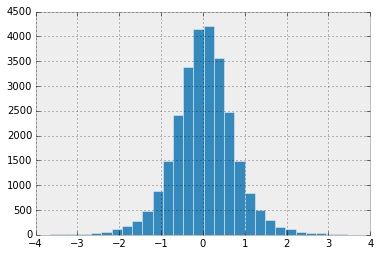

In [31]:
# L2 Coefficients

from collections import Counter
a  = plt.hist(coef2, bins=50)
plt.savefig('exp_coef_l2.png', bbox_inches="tight", dpi=200, transparent=True)
plt.xlim([-4,4])
c = Counter(coef2)
print c.most_common(3)
print "non-zero coef.:", len([x for x in coef2 if x != 0])
print "pos coef.:", len([x for x in coef2 if x > 0])
print "neg coef.:", len([x for x in coef2 if x < 0])


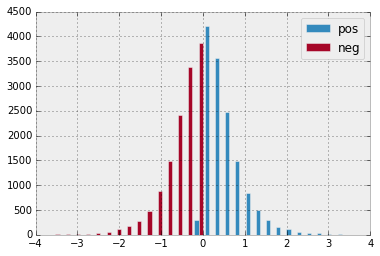

In [32]:
# Coefficients of L2 per Class
a  = plt.hist([[x for x in coef2 if x > 0],[x for x in coef2 if x < 0]], label=['pos', 'neg'], bins=50)
plt.xlim([-4,4])
plt.legend(loc='best')

[(0.0, 16975), (-0.073890477388146011, 1), (-0.21902292877787036, 1)]
non-zero coef.: 10341
pos coef.: 5369
neg coef.: 4972


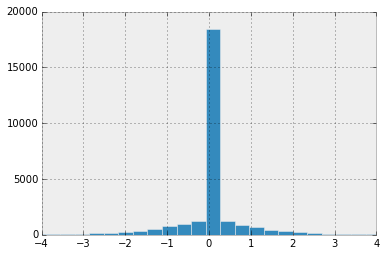

In [33]:
# Coefficients for L1 

from collections import Counter
a  = plt.hist(coef1, bins=50)
plt.savefig('exp_coef_l1.png', bbox_inches="tight", dpi=200, transparent=True)
plt.xlim([-4,4])
c2 = Counter(coef1)
print c2.most_common(3)
print "non-zero coef.:", len([x for x in coef1 if x != 0])
print "pos coef.:", len([x for x in coef1 if x > 0])
print "neg coef.:", len([x for x in coef1 if x < 0])

In [37]:
# L2 C=10 
expertl10 = exputil.get_classifier('lr', parameter=10)
expertl10.fit(exp_sent_bow, exp_lbl)
print_top_terms(expertl10, terms, n=50)
coef10 = expertl10.coef_[0]
print "non-zero coef.:", len([x for x in coef10 if x != 0])
print "pos coef.:", len([x for x in coef10 if x > 0])
print "neg coef.:", len([x for x in coef10 if x < 0])



Top Coefficients
Class-0 Terms:
yokai (19.40)
flavia (19.08)
valette (17.09)
ginty (16.39)
ae (16.31)
paulie (16.22)
deathtrap (15.83)
luger (15.65)
atoz (15.60)
wilhelm (15.39)
oro (15.17)
embezzler (14.96)
lata (14.84)
edie (14.81)
antwone (14.68)
lian (14.59)
pimlico (14.58)
gypo (14.56)
blandings (14.54)
hackett (14.31)
nekron (14.02)
kemble (14.00)
panahi (13.78)
goldsworthy (13.69)
microfilm (13.55)
heaton (13.46)
doozy (13.31)
rainbeaux (13.26)
mj (13.17)
polonius (13.16)
gabe (13.10)
nighy (13.02)
visconti (13.00)
bjm (12.91)
alta (12.87)
beckett (12.79)
trelkovsky (12.68)
bathhouse (12.55)
borden (12.49)
krell (12.43)
alonzo (12.35)
dorsey (12.33)
quibble (12.29)
pidgeon (12.28)
din (12.24)
johnston (12.21)
gilliam (12.20)
kells (12.18)
newcombe (12.18)
coonskin (12.17)

Class-1 Terms:
mallory (-21.41)
bancroft (-19.64)
condon (-17.99)
dyer (-15.39)
grodin (-15.38)
korman (-14.54)
kornbluth (-14.07)
nastassja (-14.04)
richie (-13.98)
hauer (-13.96)
chomsky (-13.73)
zealot (-1

## 3. Test: Error Analysis

Check the snippets where the expert's label is incorret but the model is highly confident. 

We select 1000 random documents and split them into snippets (sentences). We test the simulated expert classifier on the resulting snippets and check for errors. 

### IMDB Expert Error Analysis

We tested 1000 documents and their snippets. 

In [38]:
# error analysis    
def error_analysis(clf, test_x, test_y, snippets, terms, threshold=.95, sort=False, n=20):
    predicted = clf.predict(test_x)
    predicted_proba = clf.predict_proba(test_x)
    errors = predict != y_test
    print 'Accuracy: %.4f' % metrics.accuracy_score(test_y, predicted)
    print 'Test size: %s' % len(test_y)
    print '\nERRORS (P > {}):'.format(threshold)
    if sort:
        order = predicted_proba.max(axis=1).argsort()[::-1]
    else:
        order = range(predicted_proba.shape[0])
    for i in order:
        probability = predicted_proba[i][predicted[i]]
        # If we're very wrong.
        if predicted[i] != y_test[i] and probability > threshold:
            print i,
            print '\npred=%d (%g) truth=%d \ntext=%s ' % (predicted[i],
                                                            probability,
                                                            test_y[i],
                                                            snippets[i])
            print_terms_and_coef(test_x.getrow(i), terms, clf.coef_[0])

print "EXPERT L2"
error_analysis(expertl2, x_test, y_test, snippets, vct.get_feature_names(), sort=True)


EXPERT L2
Accuracy: 0.6985
Test size: 10697

ERRORS (P > 0.95):
10550 
pred=0 (0.985966) truth=1 
text=Don't waste your time with 1-3. 
Top Terms:
waste -5.951
don -1.068
your -0.085
with 0.113
time 1.032

3536 
pred=0 (0.985092) truth=1 
text=Not bad, not bad at all. 
Top Terms:
bad -4.324
not -1.031
at -0.190
all -0.167

1949 
pred=0 (0.976018) truth=1 
text=Much better than the original.<br /><br />In "Caddyshack", Rodney Dangerfield is funny, but obnoxious. 
Top Terms:
obnoxious -2.731
dangerfield -1.927
original -1.761
rodney -1.514
better -0.778
br -0.559
much -0.319
funny -0.126
than -0.066
but 0.380
in 0.391
the 0.530
is 1.577

7065 
pred=0 (0.974111) truth=1 
text=There isn't a wasted scene in this movie. 
Top Terms:
wasted -3.997
this -0.747
there -0.744
isn -0.595
movie -0.529
scene -0.196
in 0.391

10095 
pred=1 (0.972422) truth=0 
text=The serial had a solid Edmund, in an actor who was best at likable saps, and the perfect, i.e. 
Top Terms:
was -0.987
actor -0.770
had -0.6

In [39]:
print "EXPERT L1"
error_analysis(expertl1, x_test, y_test, snippets, vct.get_feature_names(), sort=True)


EXPERT L1
Accuracy: 0.6994
Test size: 10697

ERRORS (P > 0.95):
1949 
pred=0 (0.993778) truth=1 
text=Much better than the original.<br /><br />In "Caddyshack", Rodney Dangerfield is funny, but obnoxious. 
Top Terms:
dangerfield -3.744
obnoxious -3.699
original -1.778
rodney -1.433
better -0.804
br -0.557
much -0.309
funny -0.129
than -0.005
in 0.383
but 0.409
the 0.578
is 1.586

10550 
pred=0 (0.99163) truth=1 
text=Don't waste your time with 1-3. 
Top Terms:
waste -6.796
don -1.075
with 0.085
time 1.068

10095 
pred=1 (0.988137) truth=0 
text=The serial had a solid Edmund, in an actor who was best at likable saps, and the perfect, i.e. 
Top Terms:
was -0.991
actor -0.771
had -0.620
at -0.152
in 0.383
an 0.460
serial 0.515
the 0.578
likable 0.593
and 1.883
saps 2.067
edmund 2.396
best 2.510
solid 2.764
perfect 3.818

5520 
pred=0 (0.986172) truth=1 
text=And Steven Dorff, hyped in the previews, makes a more than bad enough bad guy to Snipes' hero. 
Top Terms:
bad -4.393
snipes -3.851


##4. Other Datasets: SRAA Analysis

Setting data and expert 

In [48]:
sraa, vct = load_data('sraa', SRAA_DATA)

exp_sent, exp_lbl = _sentences(sraa.train.data, sraa.train.target, sent_tk)
exp_sent_bow = vct.transform(exp_sent)


expertl2 = exputil.get_classifier('lrl2', parameter=1)
expertl1 = exputil.get_classifier('lr', parameter=1)

expertl2.fit(exp_sent_bow, exp_lbl)
expertl1.fit(exp_sent_bow, exp_lbl)

sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')

## Get Test data ready
test_docs = rnd.permutation(len(sraa.test.target))



### SRAA Top Terms

We tested L1 and L2 models to check the differences 

In [49]:
snippets, y_test = _sentences(sraa.test.data[test_docs[:n]], sraa.test.target[test_docs[:n]], sent_tk)
x_test = vct.transform(snippets)

print "Number of sentences:", len(snippets)
print "Number of features:", x_test.shape[1]


Number of sentences: 10908
Number of features: 26570


In [50]:
terms = vct.get_feature_names()
print "Classes", sraa.train.target_names

#L2 Expert
print_top_terms(expertl2, np.array(terms))
coef2 = expertl2.coef_[0]
print "Number of coef.:", len(coef2)
print "non-zero coef.:", len([x for x in coef2 if x != 0])
print "pos coef.:", len([x for x in coef2 if x > 0])
print "neg coef.:", len([x for x in coef2 if x < 0])

Classes ['auto', 'aviation']

Top Coefficients
Class-0 Terms:
fs98 (14.04)
aircraft (12.01)
fly (11.36)
flight (11.28)
pilot (11.03)
plane (10.80)
flying (10.49)
aviation (10.33)
cfi (9.96)
airplane (9.23)
airport (9.17)
landing (9.14)
landings (8.58)
scenery (8.50)
runway (8.41)
rudder (8.27)
atc (8.19)
pilots (8.18)
fs (8.06)
instructor (7.98)

Class-1 Terms:
gpl (-18.61)
racing (-13.14)
car (-13.05)
race (-11.46)
cars (-11.24)
track (-8.81)
nascar (-8.68)
wheel (-8.64)
lap (-8.29)
laps (-7.72)
papyrus (-7.66)
gp2 (-7.65)
tracks (-7.21)
f1rs (-7.07)
papy (-6.93)
driving (-6.88)
races (-6.83)
game (-6.77)
vroc (-6.40)
ferrari (-6.25)

intercept=-0.523137
Number of coef.: 26570
non-zero coef.: 26570
pos coef.: 12276
neg coef.: 14294


In [51]:
#L1 Expert  -->> repeat this !
print_top_terms(expertl1, np.array(terms))
coef1 = expertl1.coef_[0]
print "Number of coef.:", len(coef1)
print "non-zero coef.:", len([x for x in coef1 if x != 0])
print "pos coef.:", len([x for x in coef1 if x > 0])
print "neg coef.:", len([x for x in coef1 if x < 0])


Top Coefficients
Class-0 Terms:
fs98 (24.48)
cfi (19.42)
landings (18.34)
aviation (18.17)
aircraft (17.60)
atc (16.76)
faa (16.32)
pp99 (15.28)
regish (15.09)
pilot (14.90)
airplane (14.76)
fbo (14.73)
checkride (14.53)
airport (14.42)
fly (14.02)
plane (13.74)
landing (13.14)
flying (12.96)
asel (12.93)
cfs (12.83)

Class-1 Terms:
gpl (-39.37)
racing (-22.17)
f1rs (-16.53)
gp2 (-16.29)
race (-16.05)
car (-15.57)
nascar (-15.55)
laps (-15.38)
papyrus (-15.30)
cars (-15.23)
docked (-14.34)
ferrari (-14.27)
papy (-13.68)
vroc (-13.49)
prix (-12.64)
lap (-12.04)
thriller (-11.71)
races (-11.70)
track (-11.54)
monza (-11.46)

intercept=-0.581287
Number of coef.: 26570
non-zero coef.: 9856
pos coef.: 4970
neg coef.: 4886


### SRAA Expert Error Analysis

In [52]:
print "EXPERT L2"
error_analysis(expertl2, x_test, y_test, snippets, vct.get_feature_names(), sort=True)


EXPERT L2
Accuracy: 0.7785
Test size: 10908

ERRORS (P > 0.95):
351 
pred=1 (0.999271) truth=0 
text=In flight sims you
> have to taxi to the runway. 
Top Terms:
sims -3.821
the -0.067
have 0.161
in 0.262
you 0.373
to 0.433
taxi 2.805
runway 8.410
flight 11.285

9378 
pred=0 (0.999074) truth=1 
text=Anyway, the steering wheel connects via the usual joystick port, and the
pedals connect via a serial type looking connector to the steering
wheel. 
Top Terms:
wheel -8.642
steering -4.972
connect -2.982
pedals -2.275
serial -1.181
connects -1.144
connector -1.060
port -0.625
type -0.173
the -0.067
anyway -0.006
via 0.011
usual 0.172
to 0.433
looking 0.564
and 0.785
joystick 0.838

7558 
pred=1 (0.99792) truth=0 
text=I did not fly, though. 
Top Terms:
though -0.327
did 0.575
not 0.617
fly 11.358

5193 
pred=1 (0.994744) truth=0 
text=at this time" isn't going to fly. 
Top Terms:
this -0.728
at -0.280
going 0.289
isn 0.346
to 0.433
time 0.563
fly 11.358

335 
pred=1 (0.993567) truth=0 
text=

In [53]:
print "EXPERT L1"
error_analysis(expertl1, x_test, y_test, snippets, vct.get_feature_names(), sort=True)


EXPERT L1
Accuracy: 0.7729
Test size: 10908

ERRORS (P > 0.95):
351 
pred=1 (0.999924) truth=0 
text=In flight sims you
> have to taxi to the runway. 
Top Terms:
sims -4.509
the -0.100
have 0.187
in 0.190
to 0.327
you 0.394
taxi 3.298
runway 12.470
flight 12.822

9378 
pred=0 (0.999708) truth=1 
text=Anyway, the steering wheel connects via the usual joystick port, and the
pedals connect via a serial type looking connector to the steering
wheel. 
Top Terms:
wheel -10.150
steering -6.315
connect -3.494
pedals -2.484
serial -1.358
connects -1.014
connector -0.951
port -0.477
type -0.160
the -0.100
to 0.327
looking 0.547
and 0.740
joystick 0.948

7558 
pred=1 (0.999531) truth=0 
text=I did not fly, though. 
Top Terms:
though -0.296
did 0.605
not 0.668
fly 14.018

973 
pred=1 (0.999182) truth=0 
text=>MS Flightsim? 
Top Terms:
ms 0.903
flightsim 9.166

7588 
pred=1 (0.999174) truth=0 
text=>
>Thanks,
>
>David Corsi - CFI-AIM
>
>


 
Top Terms:
thanks -0.151
david 0.312
aim 2.344
cfi 19.424


##5. Other Datasets: Twitter 

We use tweets as the snippets for this dataset 

In [58]:
def load_data_twitter(dataname, path):
    import pickle
    from sklearn.datasets import base as bunch

    DATA_PKL = path + '/data.pkl'
    sample = bunch.Bunch(train=bunch.Bunch(), test=bunch.Bunch())
    if os.path.isfile(DATA_PKL):
        vct, sample = pickle.load(open(DATA_PKL, 'rb'))
    else:
        vct = exputil.get_vectorizer({'vectorizer':"tfidf", 'limit':None, 'min_size':None})
        data = datautil.load_dataset(dataname, path, categories=None, rnd=5463, shuffle=True)
        size= len(data.data)
        idx = rnd.permutation(size)
        
        train_idx = idx[:size/2]
        test_idx = idx[size/2:]
        
        sample.train.data = np.array(data.data, dtype=object)[train_idx]
        sample.test.data = np.array(data.data, dtype=object)[test_idx]

        sample.train.target = data.target[train_idx]
        sample.test.target = data.target[test_idx]

        sample.train.bow = vct.fit_transform(sample.train.data)
        sample.test.bow = vct.transform(sample.test.data)

        sample.target_names = data.target_names
        sample.train.remaining = []
        
        pickle.dump((vct, sample), open(DATA_PKL, 'wb'))

    return sample, vct


twitter, vct = load_data_twitter('twitter', TWIITER_DATA)

exp_sent, exp_lbl = _sentences(twitter.train.data, twitter.train.target, sent_tk)
exp_sent_bow = vct.transform(exp_sent)


expertl2 = exputil.get_classifier('lrl2', parameter=1)
expertl1 = exputil.get_classifier('lr', parameter=1)

expertl2.fit(exp_sent_bow, exp_lbl)
expertl1.fit(exp_sent_bow, exp_lbl)


sent_tk = exputil.get_tokenizer('tweets')

## Get Test data ready
test_docs = rnd.permutation(len(twitter.test.target))

# sent = sent_tk.tokenize_sents(twitter.test.data[test_docs[:n]])
snippets, y_test = _sentences(twitter.test.data[test_docs[:n]], twitter.test.target[test_docs[:n]], sent_tk)
x_test = vct.transform(snippets)

print "Number testing of documents:", len(sent)
print "Number of sentences:", len(snippets)
print "Number of features:", x_test.shape[1]



Number testing of documents: 782
Number of sentences: 154531
Number of features: 16533


In [59]:
# Twitter  top terms L2
terms = np.array(vct.get_feature_names())
print "Classes", twitter.target_names
print_top_terms(expertl2, terms)
coef2 = expertl2.coef_[0]
print "Number of coef.:", len(coef1)
print "non-zero coef.:", len([x for x in coef2 if x != 0])
print "pos coef.:", len([x for x in coef2 if x > 0])
print "neg coef.:", len([x for x in coef2 if x < 0])


Classes ['good', 'bots']

Top Coefficients
Class-0 Terms:
ff (5.53)
snowboard (5.38)
check (5.03)
seo (5.01)
handmade (4.95)
camping (4.88)
vc (4.82)
video (4.65)
wallpaper (4.47)
followfriday (4.33)
marketing (4.24)
success (4.13)
obama (4.12)
shazam (4.10)
affiliate (4.04)
beer (4.03)
nudes (3.96)
tourism (3.94)
business (3.93)
royalty (3.93)

Class-1 Terms:
km (-5.10)
sharepoint (-4.29)
david (-4.16)
画像 (-4.02)
fir (-3.16)
occupycentral (-3.15)
df14 (-3.02)
fuck (-3.01)
nowplaying (-2.92)
dans (-2.82)
adam (-2.79)
evernote (-2.65)
getglue (-2.64)
also (-2.62)
おはようございます (-2.56)
ニュース (-2.39)
nonprofits (-2.36)
raptors (-2.34)
dilma (-2.33)
não (-2.32)

intercept=-1.29718
Number of coef.: 26570
non-zero coef.: 16533
pos coef.: 9859
neg coef.: 6674


In [60]:
# Twitter top terms L1
print_top_terms(expertl1, np.array(terms))
coef1 = expertl1.coef_[0]
print "Number of coef.:", len(coef1)
print "non-zero coef.:", len([x for x in coef1 if x != 0])
print "pos coef.:", len([x for x in coef1 if x > 0])
print "neg coef.:", len([x for x in coef1 if x < 0])


Top Coefficients
Class-0 Terms:
snowboard (8.59)
followfriday (7.67)
affiliate (7.30)
handmade (7.08)
ziglar (6.92)
ff (6.89)
thoreau (6.70)
royalty (6.40)
camping (6.38)
seo (6.00)
vc (5.91)
check (5.58)
calgary (5.57)
tourism (5.52)
nudes (5.45)
sfgiants (5.38)
affiliates (5.33)
celebrities (5.33)
mlm (5.30)
ecommerce (5.25)

Class-1 Terms:
km (-8.87)
画像 (-7.32)
dans (-6.40)
sharepoint (-5.39)
df14 (-5.20)
fir (-5.11)
david (-4.81)
foi (-4.71)
tá (-4.68)
occupycentral (-4.24)
dilma (-4.19)
niet (-4.13)
gorge (-4.10)
isso (-4.03)
ニュース (-3.93)
muito (-3.90)
adam (-3.84)
mas (-3.83)
är (-3.73)
fuck (-3.73)

intercept=-1.35754
Number of coef.: 16533
non-zero coef.: 6761
pos coef.: 5018
neg coef.: 1743


In [64]:
coef = expertl2.coef_[0]
print expertl2.classes_
names = vct.get_feature_names()
print "\n".join('%s\t%.2f' % (names[j], coef[j]) for j in np.argsort(coef)[::-1] if coef[j] != 0)

[0 1]
ff	5.53
snowboard	5.38
check	5.03
seo	5.01
handmade	4.95
camping	4.88
vc	4.82
video	4.65
wallpaper	4.47
followfriday	4.33
marketing	4.24
success	4.13
obama	4.12
shazam	4.10
affiliate	4.04
beer	4.03
nudes	3.96
tourism	3.94
business	3.93
royalty	3.93
your	3.86
ukraine	3.79
ecommerce	3.77
top	3.76
photography	3.71
tattoo	3.66
surgery	3.65
vegas	3.64
social	3.63
agora	3.57
celebrities	3.55
via	3.53
wp	3.42
fabric	3.42
calgary	3.39
entrepreneur	3.37
traffic	3.37
barcelona	3.37
wine	3.35
hockey	3.35
sales	3.34
berlin	3.32
anime	3.29
facebook	3.27
precious	3.25
estate	3.25
launches	3.23
organic	3.17
tal	3.14
affiliates	3.14
cpu	3.13
thoreau	3.12
pussy	3.10
marketer	3.09
mlm	3.08
property	3.07
bangkok	3.06
socialmedia	3.05
obamacare	3.04
lbs	3.04
sfgiants	3.04
builders	3.03
penguin	3.02
income	3.01
bitcoin	3.01
celebrity	2.99
pictures	2.99
boards	2.98
golf	2.94
tips	2.94
tee	2.94
mexico	2.92
quotes	2.91
israel	2.91
investing	2.91
democrats	2.89
contest	2.89
cocktail	2.87
contractor	2.87


In [65]:
print "EXPERT L2"
error_analysis(expertl2, x_test, y_test, snippets, vct.get_feature_names(), sort=False)


EXPERT L2
Accuracy: 0.7051
Test size: 154531

ERRORS (P > 0.95):
235 
pred=1 (0.978565) truth=0 
text=rt THIS_IS_A_MENTION what share of vc investment dollars did israel take? THIS_IS_A_URL 
Top Terms:
rt -1.444
this_is_a_mention -1.020
did -0.054
dollars 0.098
of 0.184
this_is_a_url 0.796
take 0.939
what 1.450
share 1.938
investment 2.179
israel 2.911
vc 4.819

1411 
pred=0 (0.995461) truth=1 
text=sharepoint: THIS_IS_A_URL 
Top Terms:
sharepoint -4.289
this_is_a_url 0.796

2030 
pred=1 (0.962323) truth=0 
text=check out mypermissions on time's 50 best websites list | THIS_IS_A_URL via THIS_IS_A_MENTION #mypermissions 
Top Terms:
this_is_a_mention -1.020
out 0.197
50 0.400
time 0.463
list 0.697
this_is_a_url 0.796
on 1.067
best 1.570
websites 2.113
via 3.527
check 5.027

2125 
pred=1 (0.978225) truth=0 
text=we're building homes for millions of homeless families online and we need your help. join our team THIS_IS_A_URL 
Top Terms:
re -0.148
need -0.126
of 0.184
families 0.316
and 0.46

In [66]:
print "EXPERT L1"
error_analysis(expertl1, x_test, y_test, snippets, vct.get_feature_names(), sort=True)


EXPERT L1
Accuracy: 0.7009
Test size: 154531

ERRORS (P > 0.95):
115726 
pred=1 (0.999668) truth=0 
text=#ff #followfriday THIS_IS_A_MENTION THIS_IS_A_MENTION 
Top Terms:
this_is_a_mention -1.001
ff 6.890
followfriday 7.670

65136 
pred=0 (0.999522) truth=1 
text=i just ran 0.81 km @ a 7'03"/km pace with nike+. THIS_IS_A_URL #nikeplus 
Top Terms:
km -8.867
nikeplus -3.251
03 -0.594
ran -0.051
just 0.301
this_is_a_url 0.841
pace 1.078
with 1.147

65137 
pred=0 (0.999514) truth=1 
text=i just ran 3.95 km @ a 6'21"/km pace with nike+. THIS_IS_A_URL #nikeplus THIS_IS_A_URL 
Top Terms:
km -8.867
nikeplus -3.251
ran -0.051
just 0.301
this_is_a_url 0.841
pace 1.078
with 1.147

134818 
pred=0 (0.999399) truth=1 
text=casi me bajo en la estación de füzesabony, que está a 19 km de eger, eso por dormirme y despertar en una estación grande... 
Top Terms:
km -8.867
que -2.624
una -2.408
está -1.906
eso -1.367
de -1.272
grande -1.133
en -0.988
por -0.964
me -0.592
la -0.469
19 -0.286

27776 
pred=0 